Dissertation - Biomedical Engineering
2020/2021
Ana Catarina Monteiro Magalhães

Sensors - Zebrafish vital signs and water temperature data analysis

File: Data_analyze.ipynb

Date: 06-09-2021

Description: This notebook contains the analysis of the data obtained by the heartbeat sensors and the thermistor.  


### Imports

In [3]:
import scipy
import serial
import time
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
import scipy.signal as signal
from scipy.signal import find_peaks
from scipy import fftpack
from scipy.optimize import curve_fit
#from lmfit import Model
from numpy import exp, loadtxt, pi, sqrt
from scipy.stats import norm
import statistics

In [4]:
# Information of the fish and the section of the data
trial = 2
fish_number = 2
bn = 624
fn = 631
# time at which the data started to be saved
init = 10.92

In [7]:
if trial == 2:
    # Sampling period
    ta = 0.05
    # Cutoff frequency
    Wn = [0.01, 0.4] 
if trial == 3:
    # Sampling period
    ta = 0.01 
    # Cutoff frequency
    Wn = [0.002, 0.08]   
print(ta)
print(Wn)

0.05
[0.01, 0.4]


In [131]:
# Files from trial 2
A2_1 = "20210624-143847-peixe1.csv"
A2_2 = "20210624-145602-peixe2.csv"
A2_3 = "20210624-151249-peixe3.csv"
A2_4 = "20210624-153033-peixe4.csv"
A2_5 = "20210624-155357-peixe5.csv"

# Files from trial 3
A3_1 = "20210714-150307_peixe1.csv"
A3_2 = "20210714-152517_peixe2.csv"
A3_3 = "20210714-160833_peixe3.2.csv"
A3_4 = "20210714-162911_peixe4.csv"

          Tempo  Amplitude  Temperatura
0         10.93       4678        23.58
1         10.94       4681        23.48
2         10.95       4675        23.58
3         10.96       4683        23.48
4         10.97       5015        23.48
...         ...        ...          ...
119150  1203.29       4814        23.38
119151  1203.30       4461        23.28
119152  1203.31       4825        23.38
119153  1203.32       4849        23.38
119154  1203.33       4506        23.38

[119155 rows x 3 columns]


In [ ]:
# Read csv data
data=pd.read_csv(A4)
data.columns = ['Tempo','Amplitude', 'Temperatura']
print(data)

begin= int(bn/0.01)- int(init/0.01)
finish = int(fn/0.01)- int(init/0.01)

<IPython.core.display.Javascript object>


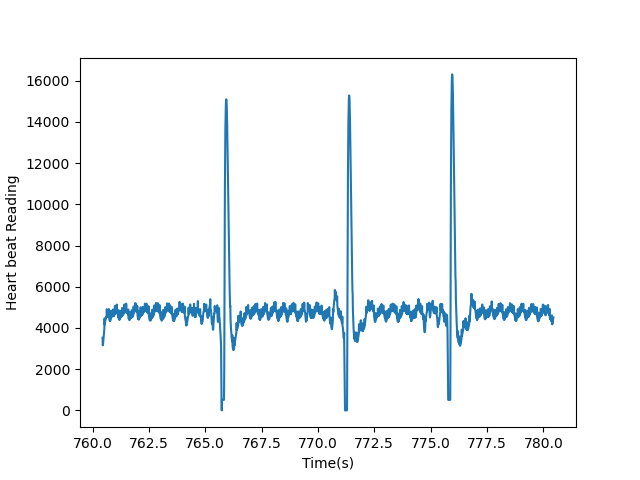

In [36]:
# Data plot
plt.plot(data['Tempo'][begin:finish],data['Amplitude'][begin:finish])
plt.xlabel('Time(s)')
plt.ylabel('Heart beat Reading')
plt.show()

## Heartbeat sensors readings

## Filtering

In [132]:
#Design the Butterworth filter
# Filter order
N  = 2      

# Application of the filter to the data
B, A = signal.butter(N, Wn,'bandpass', output='ba')
smooth_data = signal.filtfilt(B,A, data['Amplitude'][begin:finish])

In [124]:
# Plot Raw data vs Filtered data
plt.plot(data['Tempo'][begin:finish],data['Amplitude'][begin:finish],'-', color='C0', label='Raw signal', alpha = 1)
plt.plot(data['Tempo'][begin:finish],smooth_data,'k-', alpha = 0.8, label='Filtered signal')
plt.legend(['Raw signal','Filtered signal'], bbox_to_anchor = (0.35, 1))
plt.xlabel('Time (s)')
plt.ylabel('Sensor Reading')
plt.show()

## FFT

In [144]:
D = data['Amplitude'][begin:finish].to_numpy()
# FFT of the raw data
Y_raw =abs(np.fft.fft(D))
# FFT of the filtered data
Y_smooth = abs(np.fft.fft(smooth_data))

# Sampling frequency
Fa=1/Ta

N=data['Tempo'][begin:finish].size
x_fft=np.linspace(0.0,1.0/(2.0*Ta),N//2)
f_raw = 2.0/N * abs(Y_raw[:N//2]) 
f_smooth = 2.0/N * abs(Y_smooth[:N//2])
n=len(x_fft)

<IPython.core.display.Javascript object>


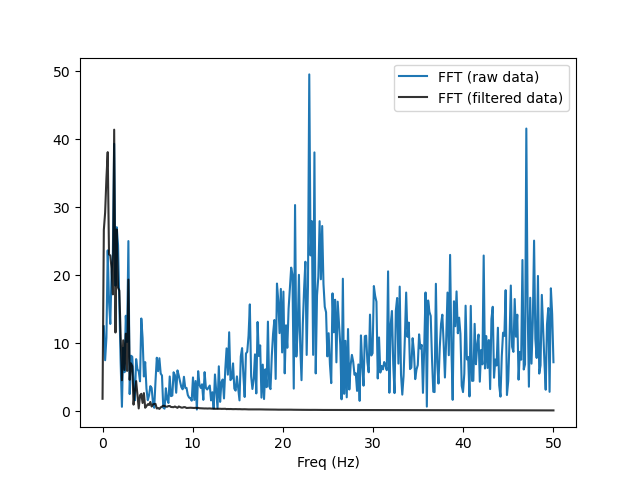

In [145]:
# Plot  Raw data FFT vs Filtered data FFT 
plt.plot(x_fft[1:],f_raw[1:], color='C0', label = 'FFT (raw data)', alpha = 1)
plt.plot(x_fft[:],f_smooth[:],'k', label = 'FFT (filtered data)', alpha = 0.8)
plt.legend(loc='best')
plt.xlabel('Freq (Hz)')
plt.show()

## Gaussian Curve Adjustment to the FFT 

In [146]:
#Gaussian functions
def gaussian(x, a, mean, sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

# Function for a sum of two gaussians
def gaussian_sum2(x, a, mean, sigma, a1, mean1, sigma1):
    return (a*np.exp(-(x-mean)**2/(2*sigma**2))) + (a1*np.exp(-(x-mean1)**2/(2*sigma1**2)))

In [150]:
# Best values for a, mean and sigma for the best gaussian curve fit
best_vals, cov_vals = curve_fit(f=gaussian, xdata=x_fft[2:], ydata = f_smooth[2:], p0=[20, 1,0.5])
print(best_vals)

[40.47365568 -1.11339457  2.16888153]


Gaussiana 1: -1.1133945716826366


<IPython.core.display.Javascript object>


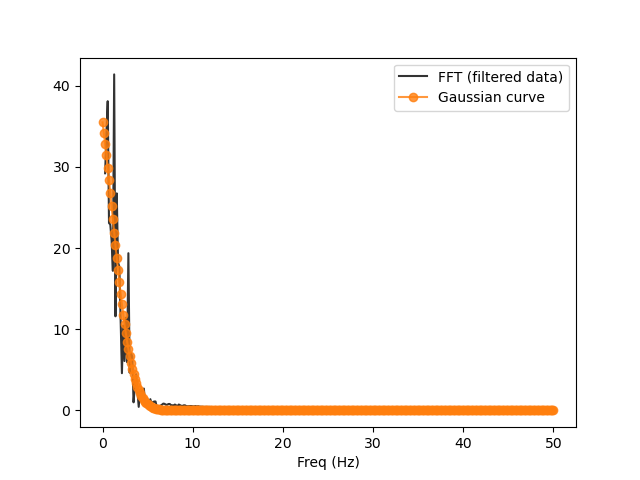

In [151]:
y_fft1 = gaussian(x_fft,best_vals[0],best_vals[1],best_vals[2])
print("Gaussiana 1: {}".format(best_vals[1]))
# y_fft2 = gaussian(x_fft,best_vals[3],best_vals[4],best_vals[5])
# print("Gaussiana 2: {}".format(best_vals[4]))


plt.plot(x_fft[2:],f_smooth[2:],'k',label='FFT (filtered data)',  alpha = 0.8)
plt.plot(x_fft,gaussian(x_fft, *best_vals),'o-',color = 'C1',label='Gaussian curve', alpha = 0.8)
plt.legend(loc='best')
plt.xlabel('Freq (Hz)')
plt.show()

## Find_peaks

Indicar quais os valores para cada segemnto dos dados (caderno argolas)

In [2]:
smooth_data = smooth_data/max(smooth_data)

# Selection of the peaks correspondent to the opercular movement
peaks_op, _ = find_peaks(smooth_data, height =1.1, distance = 35, threshold = 0.0000000001) #retorna os indices dos picos 

# Selection of all peaks present in the signal
peaks_all, _ = find_peaks(smooth_data, height =-0, distance = 35, threshold = 0.00001)
peak = peaks_all.tolist()


d = len(peak)-len(peaks_op)

# Removal of the operculum peaks - Results in the peaks correspondents to the heart
for n in range(len(peaks_op)):
    for m in range(d): 
        if peaks_op[n] == peak[m]:
            peak.remove(peak[m])
          
print("\nheart_peaks {}\n".format(peak))
print("operculum peaks {}". format(peaks_op))

plt.plot(smooth_data)
plt.plot(peak, smooth_data[peak], "x")
plt.show()

NameError: name 'smooth_data' is not defined

## Heart Rate calculation

In [134]:
heart_beat = []

for n in range(len(peak)-1):
    delta_t = data['Tempo'][peak[n+1]]-data['Tempo'][peak[n]]
    if delta_t < 10:
        f_min = 60/delta_t
        heart_beat.append(f_min)
        
    else:
        print("error")

print(heart_beat)
print(round(np.mean(heart_beat),1))

[86.95652173913027, 90.90909090909089, 77.92207792207796, 88.2352941176471, 85.71428571428581, 56.60377358490563, 88.23529411764686, 92.3076923076925, 124.99999999999989]
88.0


#### Time between two consecutive peaks

In [102]:
heart_beat = []

for n in range(len(peak)-1):
    delta_t = data['Tempo'][peak[n+1]]-data['Tempo'][peak[n]]
    heart_beat.append(delta_t)
print(heart_beat)

[0.33999999999999986, 0.5100000000000016, 0.4399999999999977, 0.3000000000000007, 0.3099999999999987, 0.2900000000000027, 0.35999999999999943, 0.5199999999999996, 0.6899999999999977]


#### Peaks time

In [11]:
t = list(data['Tempo'][begin:finish])
td = []
for m in range(len(peak)):
    u = peak[m]
    td.append(t[u])
print(td)

[624.49, 625.18, 625.84, 626.61, 627.29, 627.99, 629.05, 629.73, 630.38, 630.86]


# Calculo do erro dos sensores

87.98711449027522
17.641319177023064
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 2 0 0 0 0 0 0 0 1 0 0 1]
[56.60377358 56.96081277 57.31785196 57.67489115 58.03193033 58.38896952
 58.74600871 59.1030479  59.46008708 59.81712627 60.17416546 60.53120464
 60.88824383 61.24528302 61.60232221 61.95936139 62.31640058 62.67343977
 63.03047896 63.38751814 63.74455733 64.10159652 64.4586357  64.81567489
 65.17271408 65.52975327 65.88679245 66.24383164 66.60087083 66.95791001
 67.3149492  67.67198839 68.02902758 68.38606676 68.74310595 69.10014514
 69.45718433 69.81422351 70.1712627  70.52830189 70.88534107 71.24238026
 71.59941945 71.95645864 72.31349782 72.67053701 73.0275762  73.38461538
 73.74165457 74.09869376 74.45573295 74.81277213 75.16981132 75.52685051
 75.8838897  76.24092888 76.59796807 76.95500726 77.31204644 77.66908563
 78.02612482 78.38316401 78.7

<IPython.core.display.Javascript object>


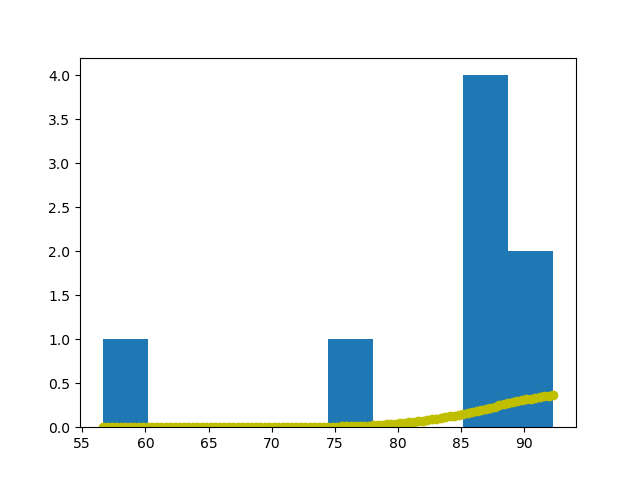

(array([1., 0., 0., 0., 0., 1., 0., 0., 4., 2.]),
 array([56.60377358, 60.17416546, 63.74455733, 67.3149492 , 70.88534107,
        74.45573295, 78.02612482, 81.59651669, 85.16690856, 88.73730044,
        92.30769231]),
 <BarContainer object of 10 artists>)

In [153]:
mean = statistics.mean(heart_beat)
sd = statistics.stdev(heart_beat)
print(mean)
print(sd)

# Histogram of the values of heart rate calculated
hist, bin_edges = np.histogram(h, bins = 100)

# Adjustment of a gaussian to the histogram
best_vals, cov_vals = curve_fit(f=gaussian, xdata=bin_edges[:-1],ydata=hist, p0=[1, mean, 2])


print("Gaussiana 1: {}".format(best_vals))
plt.plot(bin_edges,gaussian(bin_edges, *best_vals),'yo',label='gaussian_sum')
plt.hist(h)

## Thermistor Readings

In [ ]:
plt.plot(data['Tempo'], data['Temperatura'], 'ko')
plt.xlabel('Time (s)')
plt.ylabel('Temperature ($^\circ$C)')
plt.show()